In [1]:
import cv2, json, os
import numpy as np

from matplotlib import pyplot as plt

In [2]:
# Import the utilities functions
from utilities.utils import img_name_to_annot_data
from utilities.utils import plot_image
from utilities.utils import create_boolean_mask
from utilities.utils import plot_image_with_name

from utilities.utils import generate_synthetic_data
from utilities.utils import randomly_generate_synthetic_data

In [3]:
skeleton_data = [
        [0, 1], # right_ankle right_knee
        [1, 2], # right_knee right_hip
        [2, 6], # right_hip pelvis
        [6, 3], # pelvis left_hip
        [3, 4], # left_hip left_knee
        [4, 5], # left_knee left_ankle
        [12, 11], # right_shoulder right_elbow
        [11, 10], # right_elbow right_wrist
        [13, 14], # left_shoulder left_elbow
        [14, 15], # left_elbow left_wrist
        [2, 12], # right_hip right_shoulder
        [3, 13], # left_hip left_shoulder
        [2, 7], # right_hip right_thorax
        [3, 7], # left_hip thorax
        [12, 7], # right_shoulder thorax
        [13, 7], # left_shoulder thorax,
        [7, 8], # thorax upper_neck
        [8, 9], # upper_neck head_top
    ]

In [4]:
image_height, image_width = 480, 640
image_height, image_width

(480, 640)

In [5]:
# Load the annotations
annotations_path = 'resized_annotations_data.json'
valid_annot_data = None
try:
    with open(annotations_path, "r") as f:
        valid_annot_data= json.load(f)
    print("[+] Image annotations loaded successfully.")
except Exception as e:
    print("[-] Unable to load annotation data.")
    print(e)

[+] Image annotations loaded successfully.


## How the process of synthetic data generation works
<h5>We needed to attain 100% accuracy in keypoint annotations for the synthetic images as this data will be used to train the model, thus we extracted the various human poses from the training data itself and then synthetically generate the background relevant to the pose and paste the extracted human pose on the generated synthetic background.<br><br>
This is a two step process:<br>
1: Mask Generation: First we find relevant images in the relevant class using the below code, and then generate the corresponding mask of the humans in those images manually, by opening the images in an image editing tool like Mac's Preview and removing the background.<br>
We then save the image and the mask to the corresponding class directory inside the 'images' directory.<br><br>
2: Synthetic Background and Annotation Generation: We then use stable diffusion model to generate the synthetic background relevant to the image,
and generate the synthetic annotations by just modifying the corresponding annotation of the human pose in the training dataset.<br>
For generating relevant background we added the "image_name" as a "key" inside relevant class in the "prompt_dict.json" file and added a simple text description of the background relevant to the image.
</h5>
<h5>You can also add your own desired image and its mask to the corresponding class directory, and create a use "image name" to create a "key" in the<br>
corresponding class of the "prompt_dict.json" file and add the relevant background information in simple text description. This will allows us <br>
to generate background relevant to the image of a class.</h5>

## For finding relevant data

Here we will find the relevant data, i.e images,  in training dataset correpsonding to each of the 20 classes, so that we mask out the humans in those
images for generating the synthetic data

We will pick a class say "home activities" randomly select an image from this class, if the image is is okay we create its mask manually(using mac's preview tool's remove background functionality).<br>
Basically we use below code to search for images in relevant categories and then we remove background/mask them using image editing tool like Mac's preview manually.

In [6]:
# Now we group images activity wise:
activity_wise_img_info = dict()

In [7]:
# Here just grouping images by their relevant class
for i in range(len(valid_annot_data)):
    activity = valid_annot_data[i]['general_activity_name']

    if activity not in activity_wise_img_info:
        activity_wise_img_info[activity] = [valid_annot_data[i]['name']]
    else:
        (activity_wise_img_info[activity]).append(valid_annot_data[i]['name'])

In [8]:
activity_wise_img_info.keys() # Printing all the classes in data

dict_keys(['sports', 'inactivity quiet/light', 'miscellaneous', 'occupation', 'water activities', 'home activities', 'lawn and garden', 'religious activities', 'winter activities', 'conditioning exercise', 'bicycling', 'fishing and hunting', 'dancing', 'walking', 'running', 'self care', 'home repair', 'music playing', 'transportation', 'volunteer activities', '[]'])

In [9]:
class_names = {
 'sports': 0,
 'miscellaneous': 1,
 'home activities': 2,
 'occupation': 3,
 'fishing and hunting': 4,
 'home repair': 5,
 'conditioning exercise': 6,
 'lawn and garden': 7,
 'religious activities': 8,
 'music playing': 9,
 'inactivity quiet/light': 10,
 'water activities': 11,
 'running': 12,
 'winter activities': 13,
 'walking': 14,
 'dancing': 15,
 'bicycling': 16,
 'transportation': 17,
 'self care': 18,
 'volunteer activities': 19
}

In [10]:
category = 'volunteer activities' # Choosing a category to search for relevant images from which we will mask people

In [11]:
choice = np.random.randint(low=0, high=len(activity_wise_img_info[category]) - 1, size=1)[0] # make a random choice in the given class
choice

22

In [12]:
image_name = activity_wise_img_info[category][choice]
image_name

'000001163.jpg'

In [13]:
annot_data, indx = img_name_to_annot_data(image_name, valid_annot_data)

In [14]:
annotations_path='resized_annotations_data.json'
image_dir_path = '../Project2_Analysis_V_1.6/data/processed/images'
image_path = f"{image_dir_path}/{image_name}"

In [15]:
image_path, category

('../Project2_Analysis_V_1.6/data/processed/images/000001163.jpg',
 'volunteer activities')

000001163.jpg
[+] Num_person: 2 image:000001163.jpg with shape (480, 640, 3)
<class 'numpy.int64'>
<class 'numpy.int64'>


'000001163.jpg'

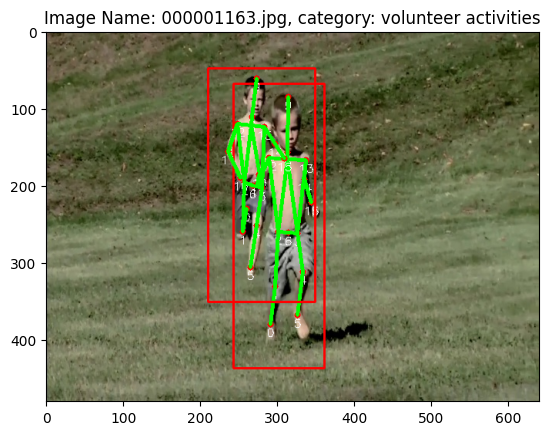

In [16]:
plot_image_with_name(image_path, annot_data, skeleton_data, category, 1, 1, image_height, image_width)

<h5>Visualising the humans pose we extracted and the corresponding mask</h5>

In [17]:
category = 'sports' # change the category here accordingly to view different categories

In [18]:
image_list = os.listdir(f'./images/{category}/images')
mask_list = os.listdir(f'./images/{category}/mask')

image_list.sort(), mask_list.sort()

(None, None)

In [19]:
image_list

['.DS_Store',
 '005024301.jpg',
 '005808361.jpg',
 '025107902.jpg',
 '065313577.jpg',
 '070807258.jpg',
 '071324479.jpg']

In [20]:
if image_list[0] == '.DS_Store':
    image_list = image_list[1:]
if mask_list[0] == '.DS_Store':
    mask_list = mask_list[1:]

In [21]:
image_list[:2], mask_list[:2]

(['005024301.jpg', '005808361.jpg'], ['005024301.png', '005808361.png'])

In [30]:
choice = np.random.randint(low=0, high=len(image_list) - 1, size=1)[0]

In [31]:
# Read in image, mask, bg
image = cv2.imread(f'./images/{category}/images/{image_list[choice]}') 
mask = cv2.imread(f'./images/{category}/mask/{mask_list[choice]}')
image.shape, mask.shape

((480, 640, 3), (480, 640, 3))

In [32]:
# Apply aa gaussian blur to mask
mask = cv2.GaussianBlur(mask, (1, 1), 0)

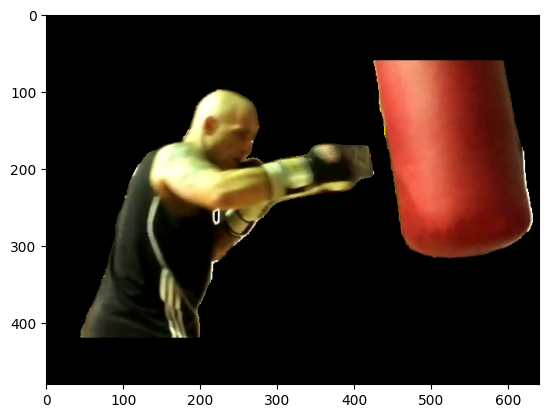

In [33]:
plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

In [34]:
real_mask = create_boolean_mask(mask)
real_mask.shape

(480, 640)

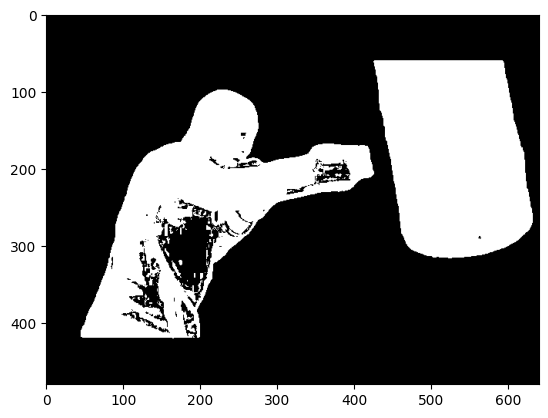

In [35]:
plt.imshow(real_mask, cmap="gray")

## Define the synthetic data generation pipeline

In [36]:
# Load the prompt dictionary for generating relevant backgrounds
prompt_dict = None
try:
    with open('prompt_dict.json', "r") as json_file:
        prompt_dict = json.load(json_file)
    print("[+] Prompt dict loaded successfully.")
except Exception as e:
    print("[-] Unable to load the prompt dict!")

[+] Prompt dict loaded successfully.


In [37]:
import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

In [38]:
model_id = "stabilityai/stable-diffusion-2-1"
pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float32)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [39]:
# These methods helps to reduce memory consumption of stable diffusion models
pipe.enable_attention_slicing()
pipe.enable_vae_slicing()
pipe.enable_vae_tiling()

In [40]:
pipe = pipe.to('mps')

<h5>We can use below code to generate synthetic images belonging to a particular class, just change the value in the category variable.</h5>

In [41]:
category = "inactivity quiet:light"

In [42]:
image_dir_path, mask_dir_path = f'./images/{category}/images', f'./images/{category}/mask'
image_dir_path, mask_dir_path

('./images/inactivity quiet:light/images',
 './images/inactivity quiet:light/mask')

In [43]:
synthetic_annotations = []
save_image_dir, save_annotations_dir = './synthetic_images', './synthetic_annotations'
synthetic_annotations, save_image_dir, save_annotations_dir

([], './synthetic_images', './synthetic_annotations')

In [60]:
generate_synthetic_data(pipe, valid_annot_data, category, prompt_dict, image_dir_path, mask_dir_path, synthetic_annotations, save_image_dir, save_annotations_dir, 720, 720, 1)

[+] I:  0
[+] Image Name:  023707729.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

./synthetic_images/023707729_2024-04-19 01:29:55.286840.jpg <class 'str'>
[+] Synthetic Image saved successfully!
[+] Synthetic image saved to ./synthetic_images/023707729_2024-04-19 01:29:55.286840.jpg
[+] Existing annotations data loaded successfully!
[+] New annotations appended successfully!
[+] Modified data saved successfully!
[+] Synthetic annotations save to ./synthetic_annotations/synthetic_annotations.json
[+] Synthetic data saved successfully!


<h5>Use the below code to randomly visualise the synthetically generated images and annotations</h5>

[+] Annotations data loaded succesfully!
[+] Choice: 39, total images: 85
023707729_2024-04-18 23:57:00.949715.jpg
[+] Num_person: 2 image:023707729_2024-04-18 23:57:00.949715.jpg with shape (720, 720, 3)
<class 'numpy.int64'>
<class 'numpy.int64'>


'023707729_2024-04-18 23:57:00.949715.jpg'

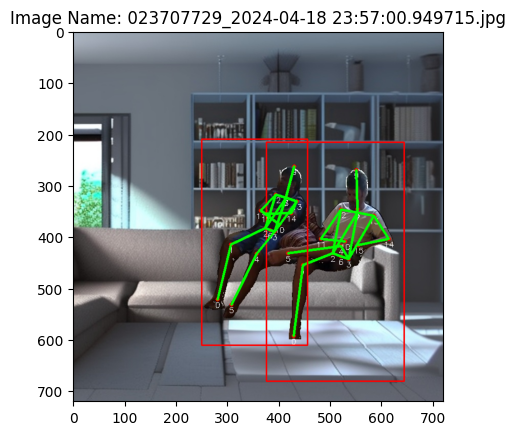

In [45]:
plot_image('./synthetic_images', './synthetic_annotations/synthetic_annotations.json', skeleton_data, 'sports', 1, 1, 720, 720)

<h4>Use the below code to randomly generate images and corresponding annotations belonging to any random class</h4>

In [38]:
category_dir_path = './images'
save_image_dir, save_annotations_dir = './synthetic_images', './synthetic_annotations'
num_data = 5
randomly_generate_synthetic_data(pipe, valid_annot_data, prompt_dict, num_data, category_dir_path, save_image_dir, save_annotations_dir)

[+] Generating an image belonging to volunteer activities as random choice: 8
[+] I:  0
[+] Image Name:  012786680.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

./synthetic_images/012786680_2024-04-19 02:09:44.490638.jpg <class 'str'>
[+] Synthetic Image saved successfully!
[+] Synthetic image saved to ./synthetic_images/012786680_2024-04-19 02:09:44.490638.jpg
[+] Existing annotations data loaded successfully!
[+] New annotations appended successfully!
[+] Modified data saved successfully!
[+] Synthetic annotations save to ./synthetic_annotations/synthetic_annotations.json
[+] Synthetic data saved successfully!
------------------------------------------------
[+] Generating an image belonging to occupation as random choice: 4
[+] I:  0
[+] Image Name:  099203847.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

./synthetic_images/099203847_2024-04-19 02:10:58.704166.jpg <class 'str'>
[+] Synthetic Image saved successfully!
[+] Synthetic image saved to ./synthetic_images/099203847_2024-04-19 02:10:58.704166.jpg
[+] Existing annotations data loaded successfully!
[+] New annotations appended successfully!
[+] Modified data saved successfully!
[+] Synthetic annotations save to ./synthetic_annotations/synthetic_annotations.json
[+] Synthetic data saved successfully!
------------------------------------------------
[+] Generating an image belonging to self care as random choice: 17
[+] I:  0
[+] Image Name:  024071243.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

./synthetic_images/024071243_2024-04-19 02:12:14.951611.jpg <class 'str'>
[+] Synthetic Image saved successfully!
[+] Synthetic image saved to ./synthetic_images/024071243_2024-04-19 02:12:14.951611.jpg
[+] Existing annotations data loaded successfully!
[+] New annotations appended successfully!
[+] Modified data saved successfully!
[+] Synthetic annotations save to ./synthetic_annotations/synthetic_annotations.json
[+] Synthetic data saved successfully!
------------------------------------------------
[+] Generating an image belonging to religious activities as random choice: 3
[+] I:  0
[+] Image Name:  087287148.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

./synthetic_images/087287148_2024-04-19 02:14:01.615971.jpg <class 'str'>
[+] Synthetic Image saved successfully!
[+] Synthetic image saved to ./synthetic_images/087287148_2024-04-19 02:14:01.615971.jpg
[+] Existing annotations data loaded successfully!
[+] New annotations appended successfully!
[+] Modified data saved successfully!
[+] Synthetic annotations save to ./synthetic_annotations/synthetic_annotations.json
[+] Synthetic data saved successfully!
------------------------------------------------
[+] Generating an image belonging to bicycling as random choice: 19
[+] I:  0
[+] Image Name:  043561186.jpg


  0%|          | 0/50 [00:00<?, ?it/s]

./synthetic_images/043561186_2024-04-19 02:15:32.872315.jpg <class 'str'>
[+] Synthetic Image saved successfully!
[+] Synthetic image saved to ./synthetic_images/043561186_2024-04-19 02:15:32.872315.jpg
[+] Existing annotations data loaded successfully!
[+] New annotations appended successfully!
[+] Modified data saved successfully!
[+] Synthetic annotations save to ./synthetic_annotations/synthetic_annotations.json
[+] Synthetic data saved successfully!
------------------------------------------------
